In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pathlib
from yawbcc.datasets import load_wbc_dataset, WBCDataSequence
from yawbcc.demo import compute_grad_cam_heatmaps, color_segmentation, unet_segmentation

### SETUP ###
DATA_DIR = pathlib.Path.home() / 'yawbcc_data'

classes = ['BASOPHIL', 'EOSINOPHIL', 'ERYTHROBLAST', 'IG', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL', 'PLATELET']
idx_to_cls = dict(enumerate(classes))
cls_to_idx = {c: i for i, c in idx_to_cls.items()}

rng = np.random.default_rng(seed=2022)

df = load_wbc_dataset('barcelona')
demodf = df.groupby('group').sample(n=10, random_state=rng.bit_generator).sort_index()
demods = WBCDataSequence(demodf['path'], demodf['group'].map(cls_to_idx), image_size=(256, 256))
images = np.concatenate([batch[0] for batch in demods])

# Load gradcam models
with tf.device('/CPU:0'):
    gc_conv = tf.keras.models.load_model(DATA_DIR / 'models' / 'gradcam_conv.hdf5')
    gc_clf = tf.keras.models.load_model(DATA_DIR / 'models' / 'gradcam_clf.hdf5')

# Load unet model
with tf.device('/CPU:0'):
    unet_cnn = tf.keras.models.load_model(DATA_DIR / 'models' / 'unet_256.hdf5')

display(demodf)

,image,group,label,path
10,BA_112418.jpg,BASOPHIL,BA,/home/damien/yawbcc_data/barcelona/basophil/BA...
313,BA_34424.jpg,BASOPHIL,BA,/home/damien/yawbcc_data/barcelona/basophil/BA...
336,BA_360297.jpg,BASOPHIL,BA,/home/damien/yawbcc_data/barcelona/basophil/BA...
399,BA_401068.jpg,BASOPHIL,BA,/home/damien/yawbcc_data/barcelona/basophil/BA...
684,BA_602999.jpg,BASOPHIL,BA,/home/damien/yawbcc_data/barcelona/basophil/BA...
...,...,...,...,...
15318,PLATELET_377730.jpg,PLATELET,PLATELET,/home/damien/yawbcc_data/barcelona/platelet/PL...
15364,PLATELET_395198.jpg,PLATELET,PLATELET,/home/damien/yawbcc_data/barcelona/platelet/PL...
15534,PLATELET_464816.jpg,PLATELET,PLATELET,/home/damien/yawbcc_data/barcelona/platelet/PL...
15952,PLATELET_616395.jpg,PLATELET,PLATELET,/home/damien/yawbcc_data/barcelona/platelet/PL...


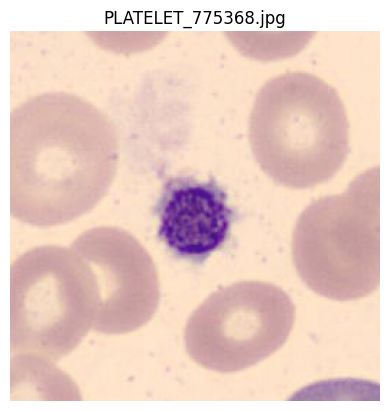

In [2]:
### INTERACTION ###
idx = rng.choice(demodf.index)
image = np.uint8(images[demodf.index.get_loc(idx)])
plt.imshow(image)
plt.title(demodf.loc[idx, 'image'])
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 484ms/step


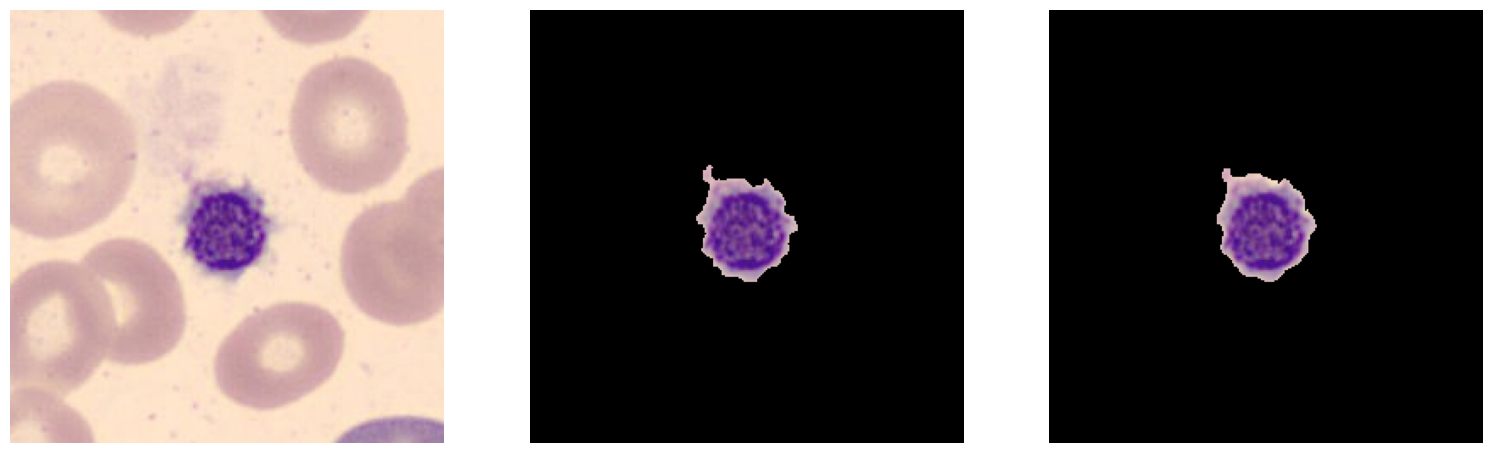

In [3]:
### SEGMENTATION ###
cmask = color_segmentation(image)
umask = unet_segmentation(image, unet_cnn)

cimg = cv2.bitwise_and(image, image, mask=cmask)
uimg = cv2.bitwise_and(image, image, mask=umask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 6))
ax1.imshow(image); ax1.axis('off')
ax2.imshow(cimg); ax2.axis('off')
ax3.imshow(uimg); ax3.axis('off')
plt.show()

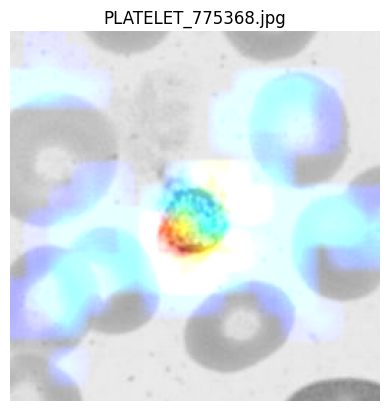

In [4]:
### GRADCAM ###
heatmap = compute_grad_cam_heatmaps(image[None], gc_conv, gc_clf)[0].astype('uint8')

cmap = plt.cm.get_cmap('jet')
colors = np.uint8(255 * cmap(np.arange(256))[:, :3])
colors[:30] = 0  # threshold low attention colors

heatmap = cv2.resize(colors[heatmap], image.shape[:2])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
gradcam = cv2.addWeighted(gray, 1, heatmap, 0.8, 0)
plt.imshow(gradcam)
plt.title(demodf.loc[idx, 'image'])
plt.axis('off')
plt.show()